In [ ]:
from tensorflow.examples.tutorials.mnist import input_data

In [ ]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

In [31]:
train_x, train_y = mnist.train.next_batch(20000)

In [4]:
train_x.shape

(2000, 784)

In [30]:
test_x, test_y = mnist.test.next_batch(5000)

### Visualization

In [5]:
import matplotlib.pyplot as plt

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


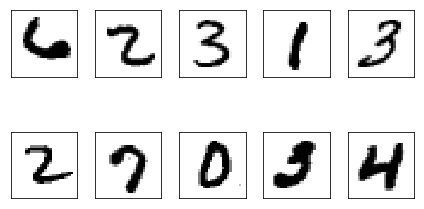

In [9]:
plt.rc('image', cmap='binary')
for i in range(10):# print 10 image
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28,28))
    print(train_y[i])
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

### FNN

In [11]:
from keras.models import Sequential
from keras.layers import Dense

In [112]:
def model1():
    model = Sequential()
    model.add(Dense(784,activation='relu'))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    return model   

In [113]:
m = model1()
m.compile(optimizer='adam', loss='categorical_crossentropy')

In [114]:
history = m.fit(train_x, train_y, epochs=10, batch_size=32, verbose=0)

In [33]:
pred = m.predict(test_x)

In [34]:
from sklearn.metrics import accuracy_score

In [35]:
accuracy_score(pred.argmax(1), test_y.argmax(1))

0.9698

### leNet 

In [37]:
import torch

In [38]:
import torch.nn as nn

In [42]:
import torch.nn.functional as F

In [39]:
import torch.optim

In [40]:
import torchvision

In [47]:
import torchvision.transforms as transforms

In [44]:
import torchvision.datasets as datasets

In [45]:
import os 
import random
import numpy as np

In [56]:
data_trans = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor()
#   ,transforms.Normalize((),())
])

### Image Normoalize
object : 将图片进行归一化缩放（X-mean)/std

思考：图片归一化后，真的不存在小于0或者大于1的outlier了吗？

思考：归一化后

In [50]:
np.mean(mnist.train.images)

0.1307003

In [52]:
np.std(mnist.train.images)

0.30815956

In [55]:
data_trans = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((.1307),(.3081))
])

In [118]:
train_data=datasets.MNIST('data',train=True,download=True,transform=data_trans)
test_data=datasets.MNIST('data',train=False,download=True,transform=data_trans)

In [59]:
n_train = int(len(train_data)*0.9)
n_validation = len(train_data) - n_train

In [119]:
train_data,valid_data=torch.utils.data.random_split(train_data,[n_train,n_validation])

In [120]:
print(len(train_data), len(valid_data), len(test_data))

54000 6000 10000


In [63]:
batch_size = 64 

目前完成了数据集的制作

In [121]:
train_iterator = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
test_iterator = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [124]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        #第一层conv1卷积层， in_channel=1, output_channel=6, kernel_size = 5*5
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10) # 不用加softmax层，在corss_entropy的Loss层中自动增加了Softmax
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x       

到此神经网络定义完毕

### 载入模型并训练

In [125]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [126]:
model = LeNet().to(device)

In [127]:
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

In [128]:
optimizer = torch.optim.Adam(model.parameters())
criterion=nn.CrossEntropyLoss()

### 如何评测结果--计算精确度

In [134]:
def accu(fx, y):
    pred = fx.max(1, keepdim=True)[1]
    correct = pred.eq(y.view_as(pred)).sum()
    acc = correct.float()/pred.shape[0]
    return acc

In [130]:
def train(model,device,iterator,optimizer,criterion):
    epoch_loss=0#积累变量
    epoch_acc=0#积累变量
    model.train()#该函数表示PHASE=Train
    
    for (x,y) in iterator:#拿去每一个minibatch
        x=x.to(device)
        y=y.to(device)
        optimizer.zero_grad()
        fx=model(x)#进行forward
        loss=criterion(fx,y)#计算Loss,train_loss
        type(loss)
        acc=accu(fx,y)#计算精确度，train_accu
        loss.backward()#进行BP
        optimizer.step()#统一更新模型
        epoch_loss+=loss.item()
        epoch_acc+=acc.item()
        
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

In [104]:
def evaluate(model,device,iterator,criterion):
    epoch_loss=0
    epoch_acc=0
    model.eval()
    with torch.no_grad():
        for (x,y) in iterator:
            x=x.to(device)
            y=y.to(device)
            fx=model(x)
            loss=criterion(fx,y)
            acc=accu(fx,y)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

# start train

In [100]:
epochs=10
model_dir='models'
model_path=os.path.join(model_dir,'lenet_mnist.pt')

In [105]:
best_valid_loss=float('inf')

In [106]:
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

In [135]:
for epoch in range(epochs):
    train_loss,train_acc=train(model,device,train_iterator,optimizer,criterion)
    valid_loss,valid_acc=evaluate(model,device,valid_iterator,criterion)
    if valid_loss<best_valid_loss:#如果是最好的模型就保存到文件夹
        best_valid_loss=valid_loss
        torch.save(model.state_dict(),model_path)
    print('Epoch:{0}|Train Loss:{1}|Train Acc:{2}|Val Loss:{3}|Val Acc:{4}'.format(epoch+1,train_loss,train_acc,valid_loss,valid_acc))

Epoch:1|Train Loss:0.27957420936075006|Train Acc:0.9136305292494489|Val Loss:0.11500227784222745|Val Acc:0.9648160465220188
Epoch:2|Train Loss:0.07811058227687863|Train Acc:0.9749950632382344|Val Loss:0.06998286420043479|Val Acc:0.9789450358837208
Epoch:3|Train Loss:0.05393652880114119|Train Acc:0.9834431773537143|Val Loss:0.05595155837053948|Val Acc:0.9833776595744681
Epoch:4|Train Loss:0.04243401201360228|Train Acc:0.9864484597156398|Val Loss:0.06212549500088108|Val Acc:0.981216755319149
Epoch:5|Train Loss:0.03428043748397751|Train Acc:0.9892007306712498|Val Loss:0.054498820526010176|Val Acc:0.9832114361702128
Epoch:6|Train Loss:0.028806797855520417|Train Acc:0.99103352095561|Val Loss:0.05036632982181742|Val Acc:0.9844304082241464
Epoch:7|Train Loss:0.02527874791100886|Train Acc:0.9915025177725119|Val Loss:0.036658450317113324|Val Acc:0.9883643617021277
Epoch:8|Train Loss:0.021336429714339994|Train Acc:0.9929835604265402|Val Loss:0.04410999297025673|Val Acc:0.9863696808510638
Epoch:9

In [99]:
epochs

0